In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Read Data

In [59]:
weather20 = pd.read_csv('data/aus20-22.csv')
weather22 = pd.read_csv('data/aus22-24.csv')
weather24 = pd.read_csv('data/aus24.csv')

In [60]:
weather_all = pd.concat([weather20,weather22,weather24]).reset_index(drop=True).drop_duplicates()

In [63]:
weather_all['datetime'] = pd.to_datetime(weather_all['datetime'])
weather_all = weather_all.set_index('datetime')

In [64]:
cutoff = '2024-03-22'
weather = weather_all[:cutoff]

In [65]:
weather.columns

Index(['name', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'sunrise', 'sunset',
       'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [68]:
features = ['tempmax', 'tempmin', 'temp', 'humidity', 'precip','snow', 'snowdepth', 'windspeed', 'conditions', 'description']
weather_f = weather[features]

In [69]:
def to_metric(df):
    df.loc[:, ['tempmax', 'tempmin', 'temp']] = (df.loc[:, ['tempmax', 'tempmin', 'temp']] - 32) * 5/9
    df.loc[:, ['precip', 'snow', 'snowdepth']] = df.loc[:, ['precip', 'snow', 'snowdepth']] * 25.4
    df.loc[:, 'windspeed'] = df.loc[:, 'windspeed'] * 1.60934
    df.loc[:, 'conditions'] = df.loc[:, 'conditions'].str.lower()
    df.loc[:, 'raining'] = df['conditions'].str.contains('rain').astype(int)
    df.loc[:, 'snowing'] = df['conditions'].str.contains('snow').astype(int)

to_metric(weather_f)


C:\Users\Acer\AppData\Local\Temp\ipykernel_4104\3060326518.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'raining'] = df['conditions'].str.contains('rain').astype(int)
C:\Users\Acer\AppData\Local\Temp\ipykernel_4104\3060326518.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'snowing'] = df['conditions'].str.contains('snow').astype(int)


In [71]:
weather_all = weather_all[features]
to_metric(weather_all)

## Heavy Weather Function

In [72]:
precip_threshold = weather_f['precip'].quantile(0.95)
snow_threshold = 10
windspeed_threshold = 45
tempmax_threshold = 35
tempmin_threshold = -3
humidity_threshold = 90

heavy rain with threshold p95, heavy snowfall with threshold 10 mm, heavy wind at over 45 kph, maxtemp over 32, mintemp  -3

In [73]:
weather_f.loc[:, 'heavy_weather'] = (
    (weather_f['precip'] > precip_threshold) |
    (weather_f['snow'] > snow_threshold) |
    (weather_f['windspeed'] > windspeed_threshold) |
    (weather_f['tempmax'] > tempmax_threshold) |
    (weather_f['tempmin'] < tempmin_threshold) |
    (weather_f['humidity'] > humidity_threshold)
).astype(int)

C:\Users\Acer\AppData\Local\Temp\ipykernel_4104\3317382555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_f.loc[:, 'heavy_weather'] = (


In [74]:
weather_all.loc[:, 'heavy_weather'] = (
    (weather_all['precip'] > precip_threshold) |
    (weather_all['snow'] > snow_threshold) |
    (weather_all['windspeed'] > windspeed_threshold) |
    (weather_all['tempmax'] > tempmax_threshold) |
    (weather_all['tempmin'] < tempmin_threshold) |
    (weather_all['humidity'] > humidity_threshold)
).astype(int)

In [24]:
len(weather_f.loc[weather_f['heavy_weather']==1])

202

<Axes: xlabel='datetime'>

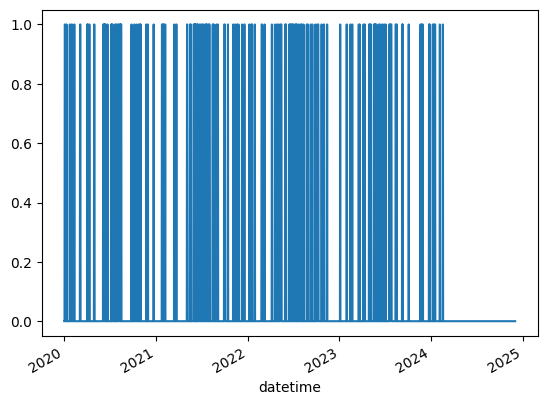

In [77]:
weather_all['heavy_weather'].plot()

<Axes: xlabel='datetime'>

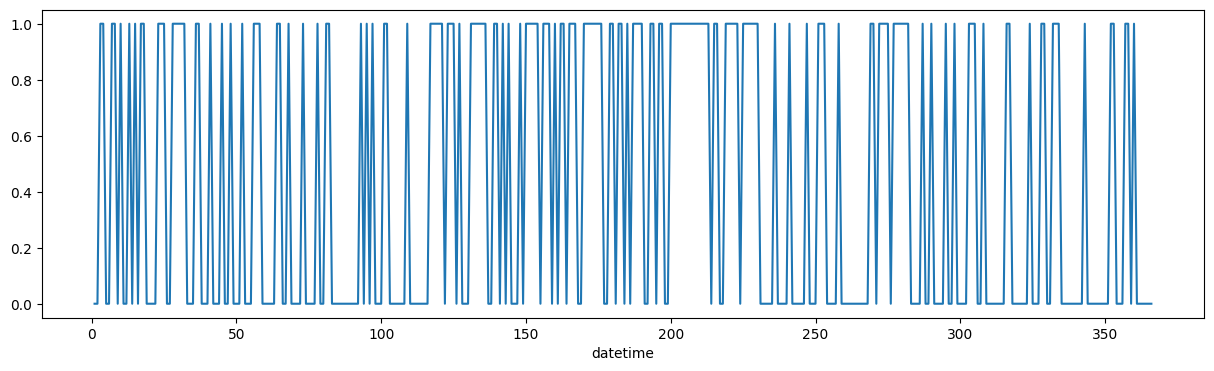

In [25]:
plt.figure(figsize=(15,4))
weather_f.groupby(by=weather_f.index.dayofyear)['heavy_weather'].sum().apply(lambda x: 1 if x>0 else 0).plot()

In [26]:
weather_clean = weather_f.drop(columns=['temp','snowdepth','conditions','description','raining', 'snowing', 'heavy_weather'])

<Axes: >

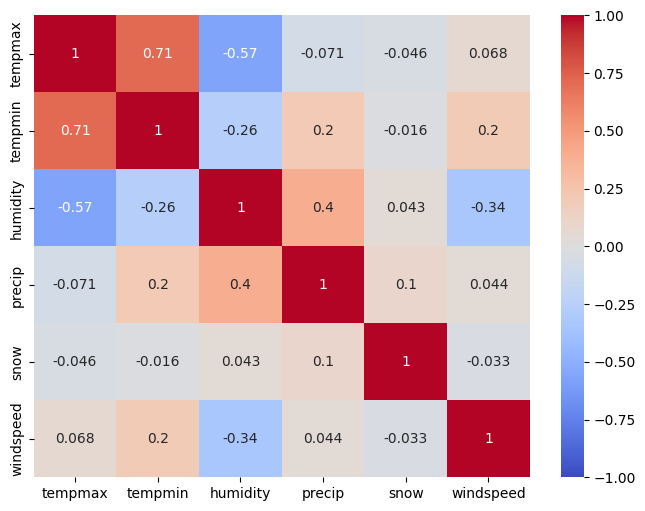

In [27]:
plt.figure(figsize=(8,6))
sns.heatmap(weather_clean.corr(), vmin=-1,vmax=1,annot=True,cmap='coolwarm')

## Forecast

In [28]:
def perform_dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('Critical Values:' , result[4])

In [29]:
forecast_features = ['tempmax', 'tempmin', 'humidity', 'precip', 'snow', 'windspeed']
for feature in forecast_features:
    print(f'Dickey Fuller test for feature {feature}')
    perform_dickey_fuller_test(weather_clean[feature])

Dickey Fuller test for feature tempmax
Test statistic:  -2.4349523945841494
Critical Values: {'1%': -3.4346537865963596, '5%': -2.8634408535813285, '10%': -2.5677819879092625}
Dickey Fuller test for feature tempmin
Test statistic:  -2.561764749340172
Critical Values: {'1%': -3.4346623009329513, '5%': -2.8634446113978034, '10%': -2.5677839889683494}
Dickey Fuller test for feature humidity
Test statistic:  -4.1957194484221345
Critical Values: {'1%': -3.434656620970318, '5%': -2.863442104538126, '10%': -2.5677826540508275}
Dickey Fuller test for feature precip
Test statistic:  -33.15029038834797
Critical Values: {'1%': -3.434595114822311, '5%': -2.863414958407463, '10%': -2.5677681986257843}
Dickey Fuller test for feature snow
Test statistic:  -39.281038682804606
Critical Values: {'1%': -3.434595114822311, '5%': -2.863414958407463, '10%': -2.5677681986257843}
Dickey Fuller test for feature windspeed
Test statistic:  -22.55573350378591
Critical Values: {'1%': -3.4345978724183603, '5%': -2.

Conclude that :  
1. tempmax is **stationary**
2. tempmin is **stationary**
3. humidity is **stationary**
4. precip is **stationary**
5. snow is **stationary**
6. windspeed is **stationary**

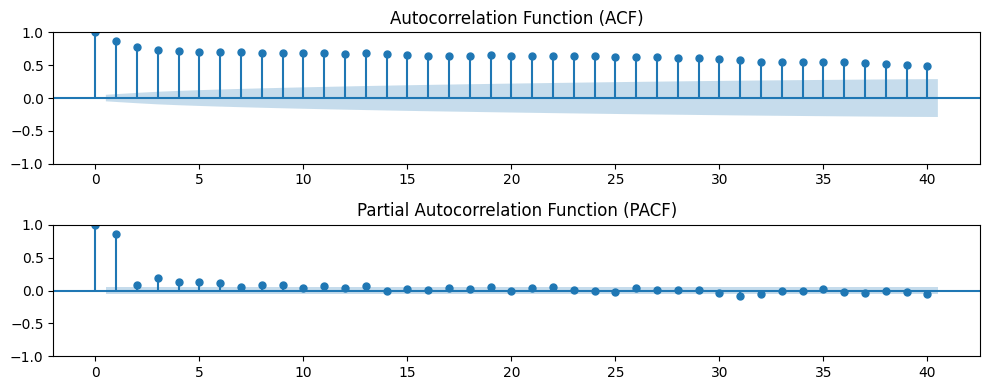

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4))

# ACF plot
plot_acf(weather_clean['tempmax'], lags=40, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(weather_clean['tempmax'], lags=40, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [31]:
weather_clean

,tempmax,tempmin,humidity,precip,snow,windspeed
datetime,,,,,,
2020-01-01,32.833333,13.833333,42.0,0.1524,0.0,21.243288
2020-01-02,32.777778,10.944444,53.3,0.0000,0.0,23.818232
2020-01-03,37.055556,16.055556,47.0,0.0000,0.0,27.680648
2020-01-04,42.888889,18.888889,38.8,0.0000,0.0,37.014820
2020-01-05,26.611111,14.833333,57.3,0.0000,0.0,27.036912
...,...,...,...,...,...,...
2024-03-18,22.666667,14.777778,80.7,0.5080,0.0,19.955816
2024-03-19,28.944444,15.166667,65.5,0.0000,0.0,20.599552
2024-03-20,22.944444,10.944444,66.4,3.1242,0.0,25.910374


In [32]:
from sklearn.metrics import mean_absolute_error

Forecasting feature tempmax


c:\Users\Acer\anaconda3\envs\angusta\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


4.4125066338960135


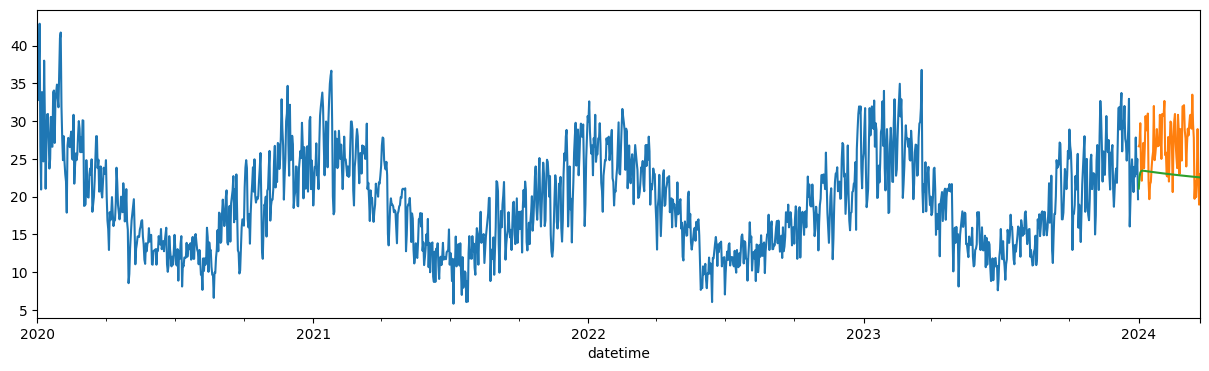

Forecasting feature tempmin
3.123680437463246


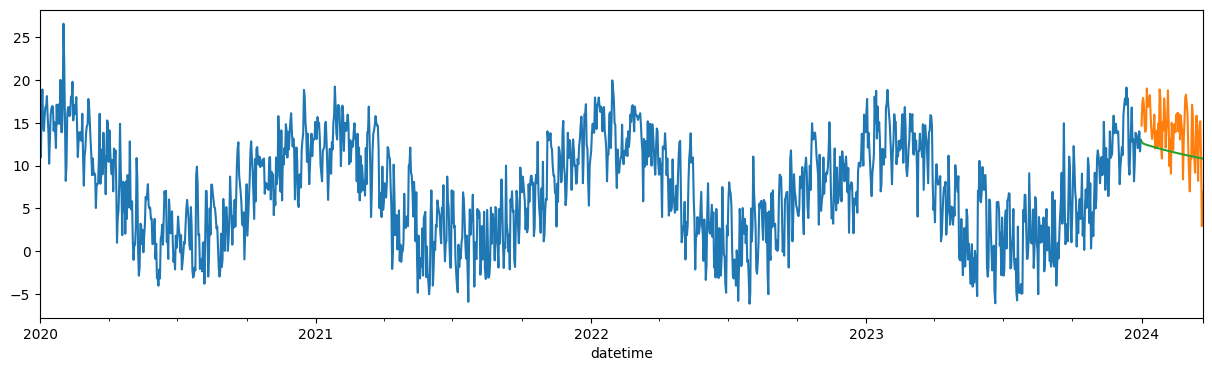

Forecasting feature humidity
7.246113239026962


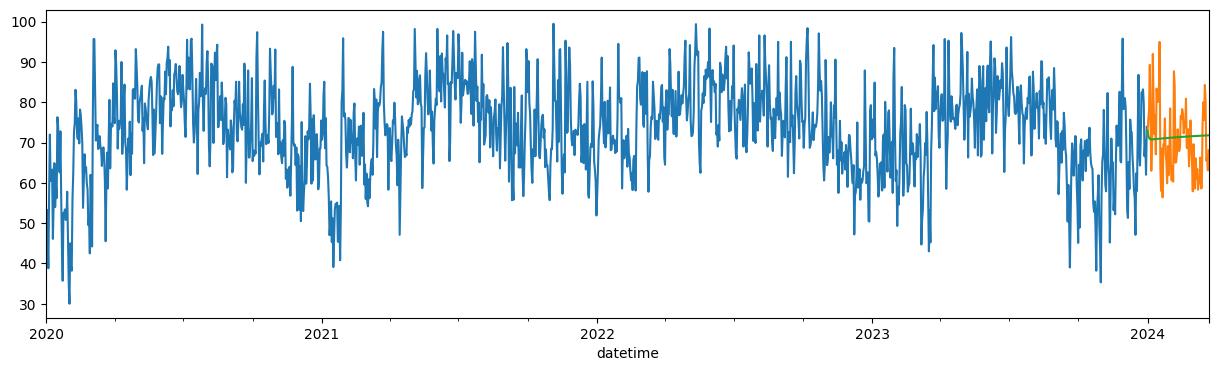

Forecasting feature precip
2.9889804988582998


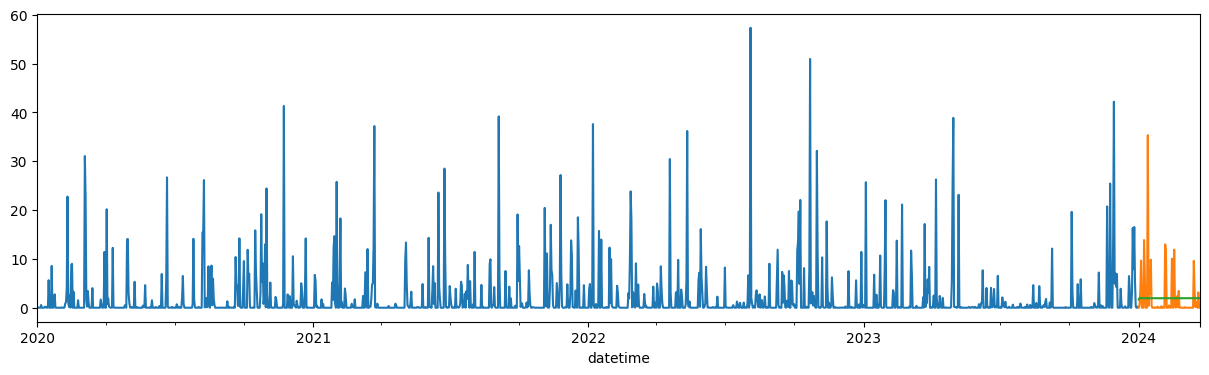

Forecasting feature snow
0.005207233200400894


c:\Users\Acer\anaconda3\envs\angusta\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Acer\anaconda3\envs\angusta\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


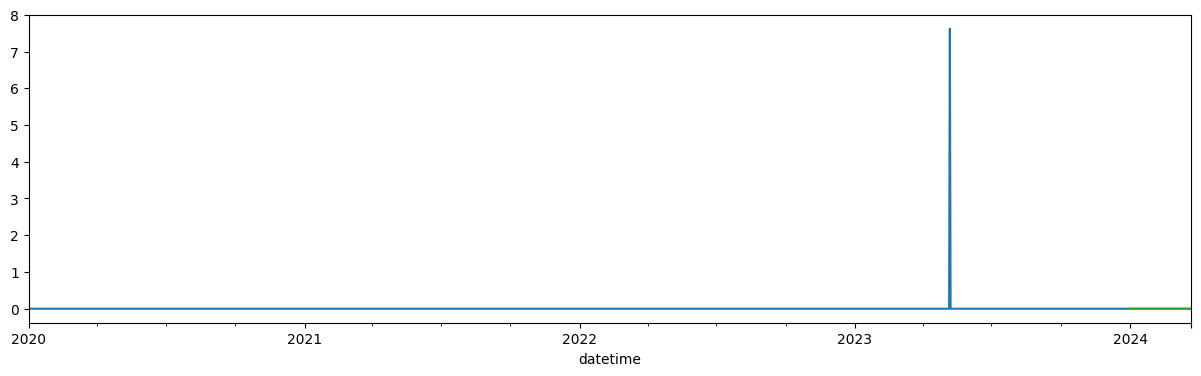

Forecasting feature windspeed
4.184869238283819


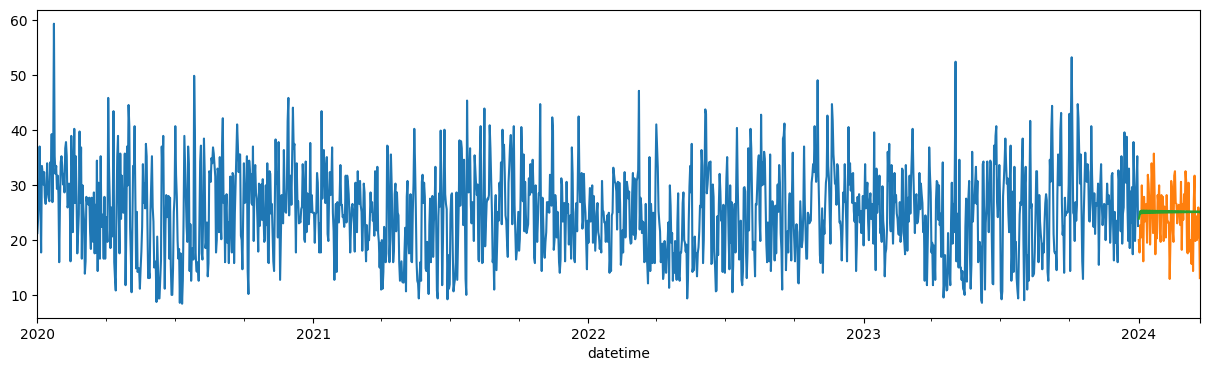

In [33]:
arima_dict = {}
for feature in forecast_features:
    print(f'Forecasting feature {feature}')
    train_series = weather_clean[feature][:'2023-12-31']
    train_series.index = pd.DatetimeIndex(train_series.index).to_period('D')
    test_series = weather_clean[feature]['2024-01-01':]
    test_series.index = pd.DatetimeIndex(test_series.index).to_period('D')
    model = ARIMA(train_series, order=(2, 0, 2))
    model_fit = model.fit()
    
    forecast_steps = 82  # Forecast for 365 days
    forecast = model_fit.forecast(steps=forecast_steps)
    forecast.index = test_series.index
    mae = mean_absolute_error(forecast, test_series)
    arima_dict[feature] = mae
    print(mae)
    
    plt.figure(figsize=(15,4))
    train_series.plot()
    test_series.plot()
    forecast.plot()
    plt.show()
    

Forecasting feature tempmax
Mean Absolute Error: 7.808586629560632


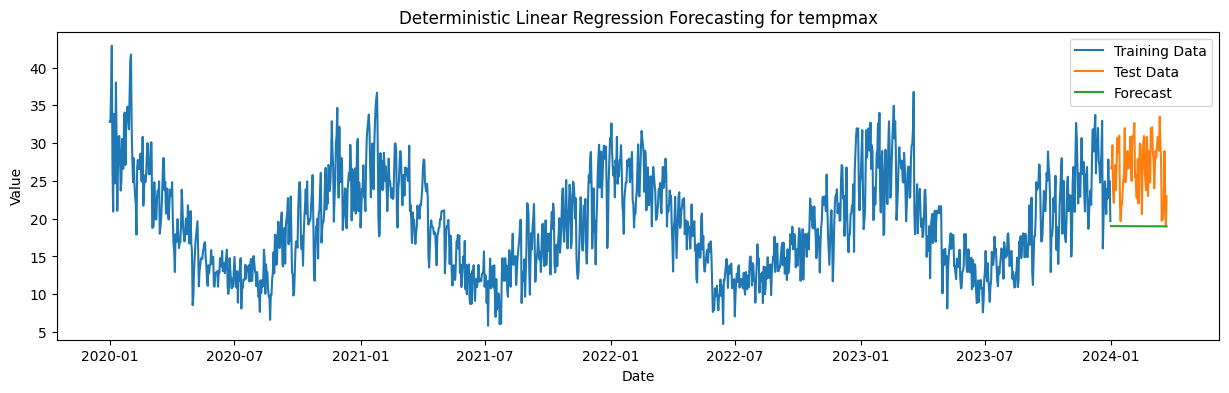

Forecasting feature tempmin
Mean Absolute Error: 7.91337206975479


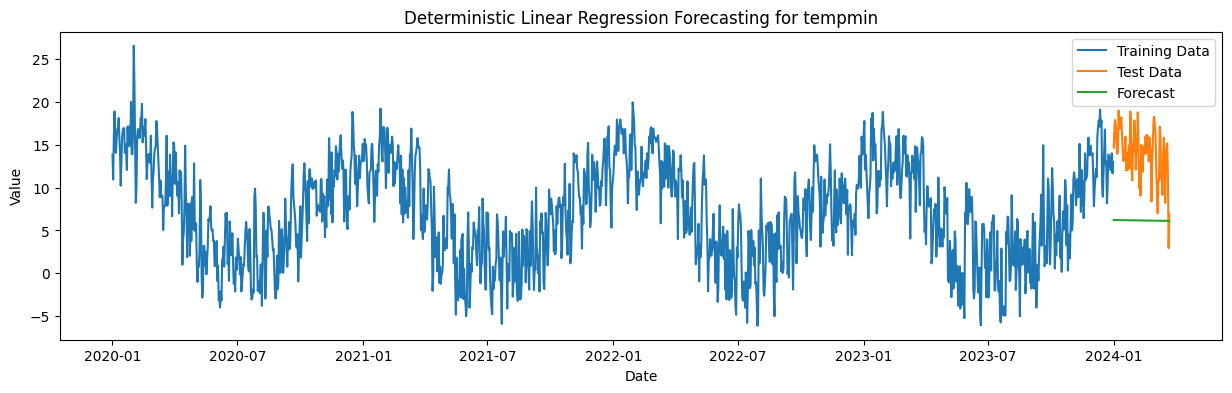

Forecasting feature humidity
Mean Absolute Error: 7.761725329700689


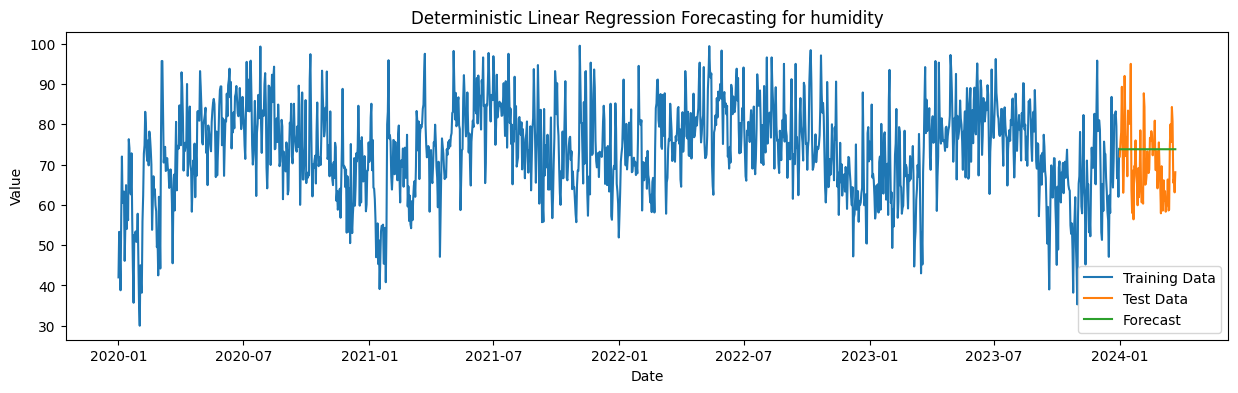

Forecasting feature precip
Mean Absolute Error: 3.008877161399814


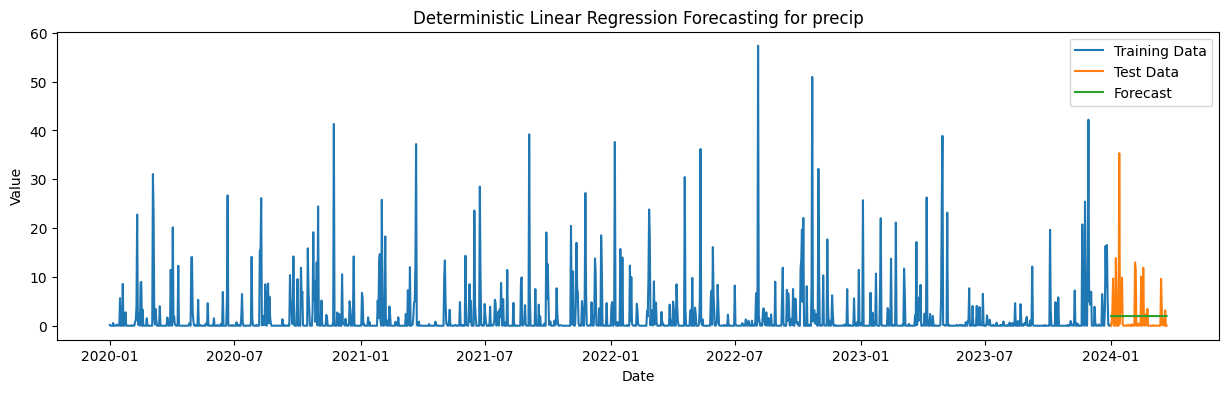

Forecasting feature snow
Mean Absolute Error: 0.016337494749253983


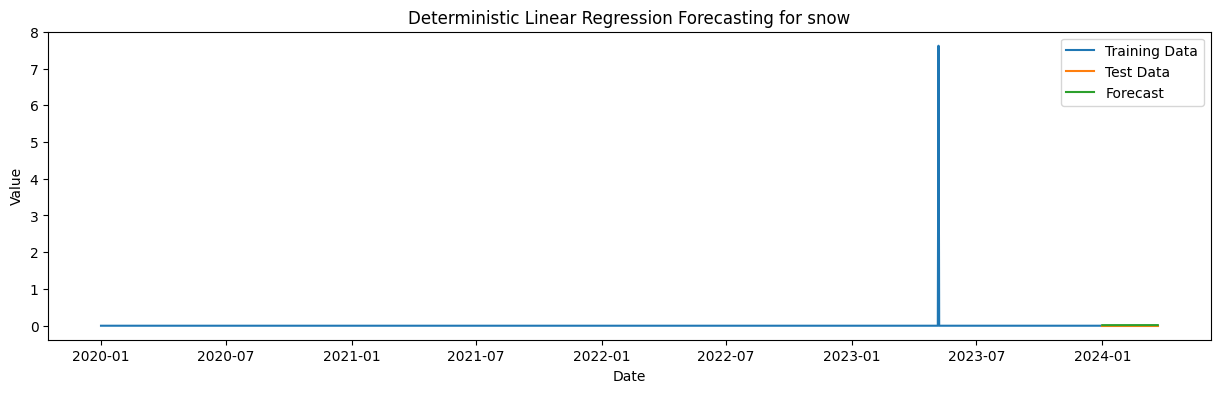

Forecasting feature windspeed
Mean Absolute Error: 4.19375397121472


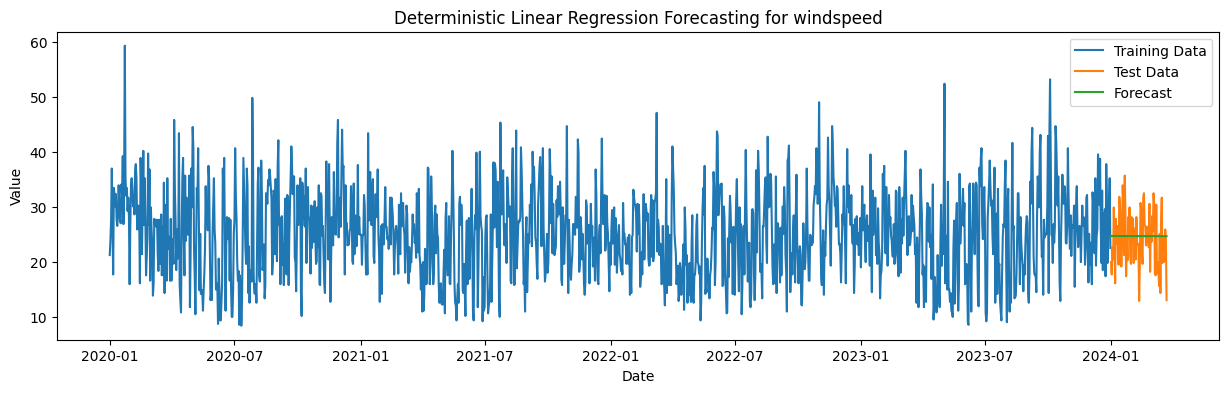

In [34]:
from sklearn.linear_model import LinearRegression

linreg_dict = {}
for feature in forecast_features:
    print(f'Forecasting feature {feature}')
    
    # Split data into train and test
    train_series = weather_clean[feature][:'2023-12-31']
    test_series = weather_clean[feature]['2024-01-01':]
    
    # Calculate linear trend parameters
    x_train = np.arange(len(train_series)).reshape(-1, 1)  # Using indices as x-values
    y_train = train_series.values.reshape(-1, 1)
    
    # Fit linear regression manually
    slope, intercept = np.polyfit(x_train.flatten(), y_train.flatten(), 1)
    
    # Forecast using the deterministic linear function
    forecast_steps = 82
    forecast_index = pd.date_range(start='2024-01-01', periods=forecast_steps)
    forecast = intercept + slope * np.arange(len(train_series), len(train_series) + forecast_steps)
    
    # Calculate MAE
    mae = mean_absolute_error(test_series, forecast[:len(test_series)])
    linreg_dict[feature] = mae
    print("Mean Absolute Error:", mae)
    
    # Plotting
    plt.figure(figsize=(15, 4))
    sns.lineplot(data=train_series, label='Training Data')
    sns.lineplot(data=test_series, label='Test Data')
    sns.lineplot(x=forecast_index, y=forecast, label='Forecast')
    plt.title(f'Deterministic Linear Regression Forecasting for {feature}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


c:\Users\Acer\anaconda3\envs\angusta\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Forecasting feature tempmax


13:38:29 - cmdstanpy - INFO - Chain [1] start processing
13:38:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 3.4483218115229244


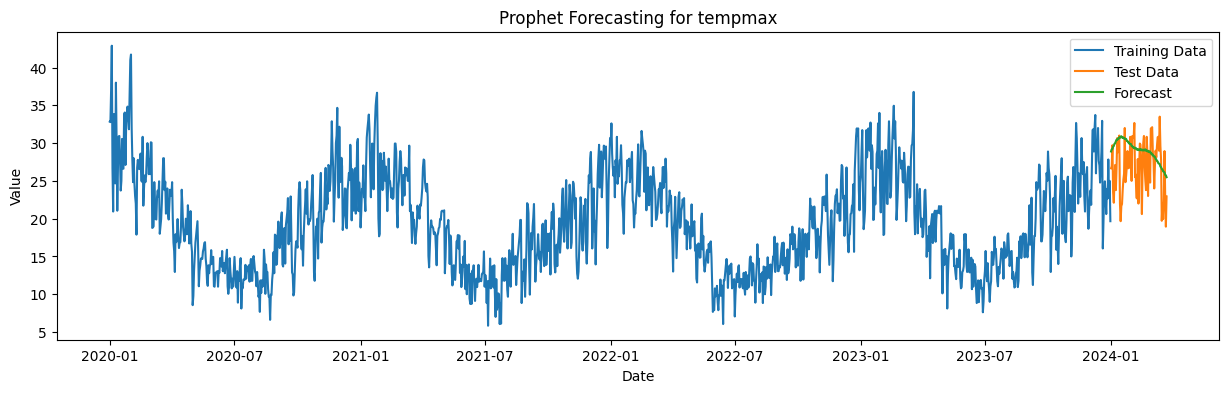

Forecasting feature tempmin


13:38:30 - cmdstanpy - INFO - Chain [1] start processing
13:38:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 2.448145610123615


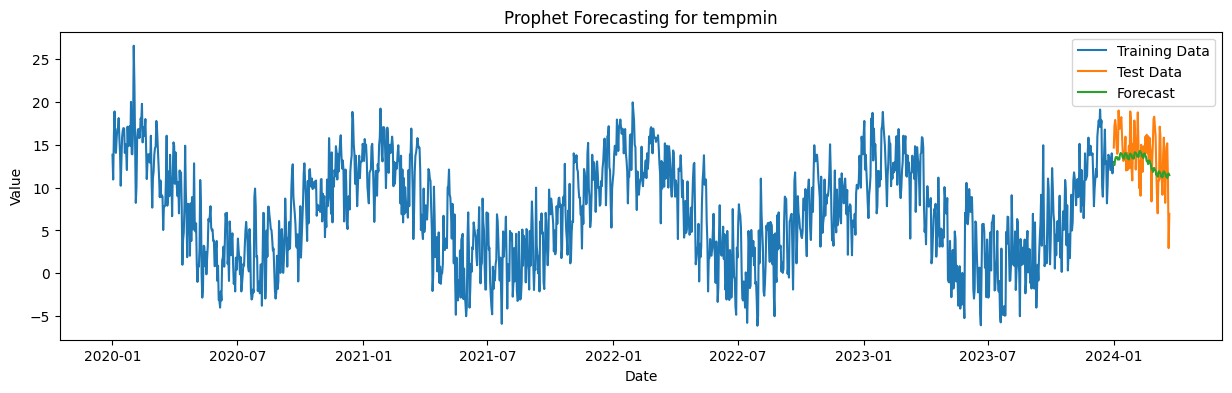

Forecasting feature humidity


13:38:31 - cmdstanpy - INFO - Chain [1] start processing
13:38:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 8.898543664533166


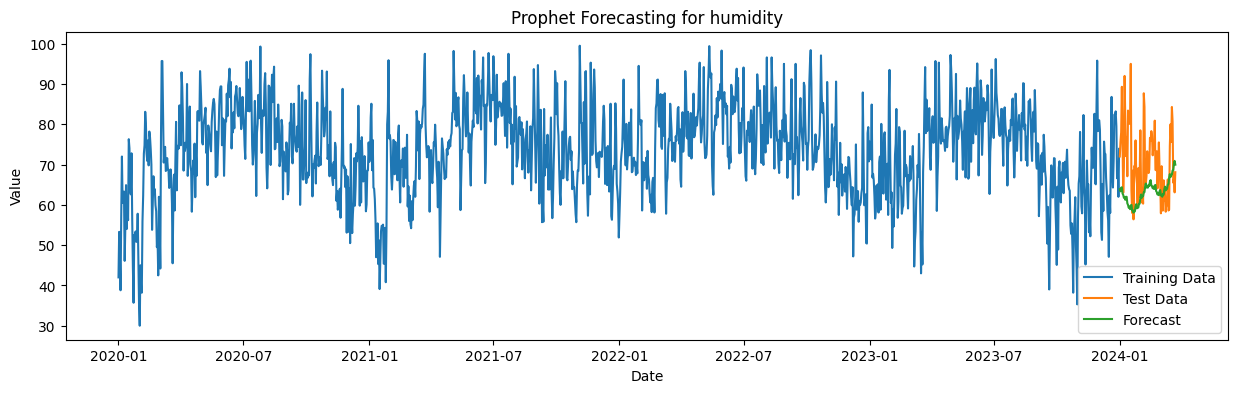

Forecasting feature precip


13:38:33 - cmdstanpy - INFO - Chain [1] start processing
13:38:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 2.887891306009772


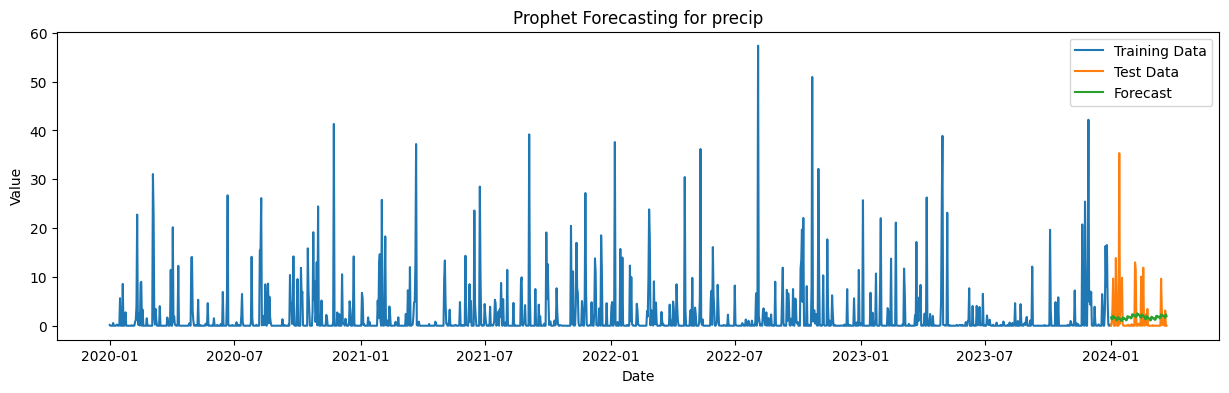

Forecasting feature snow


13:38:34 - cmdstanpy - INFO - Chain [1] start processing
13:38:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.011960316011807755


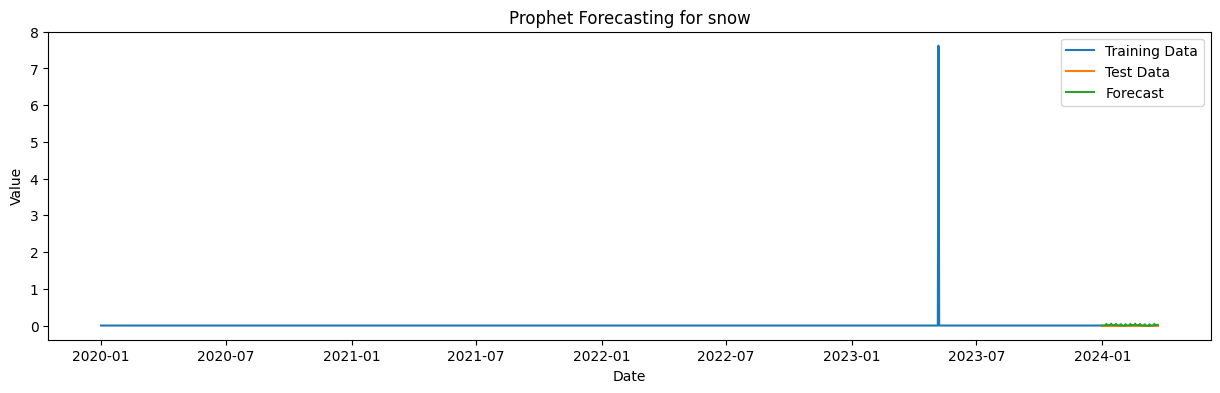

Forecasting feature windspeed


13:38:35 - cmdstanpy - INFO - Chain [1] start processing
13:38:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 4.287455359854854


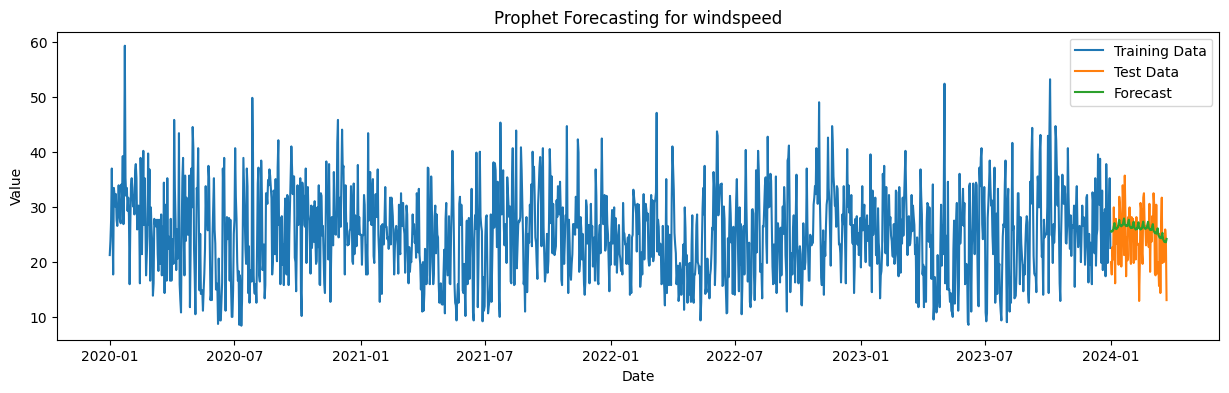

In [35]:
from prophet import Prophet

prophet_dict = {}
for feature in forecast_features:
    print(f'Forecasting feature {feature}')
    
    # Prepare data for Prophet
    df = weather_clean[[feature]].reset_index()
    df.columns = ['ds', 'y']  # Prophet expects columns named 'ds' (datetime) and 'y' (value)
    
    # Split data into train and test
    train_df = df[df['ds'] <= '2023-12-31']
    test_df = df[df['ds'] >= '2024-01-01']
    
    # Fit Prophet model
    model = Prophet()
    model.fit(train_df)
    
    # Make future dataframe for forecasting
    future = model.make_future_dataframe(periods=len(test_df), freq='D', include_history=False)
    
    # Forecast
    forecast = model.predict(future)
    
    # Calculate MAE
    mae = mean_absolute_error(test_df['y'], forecast['yhat'][:len(test_df)])
    prophet_dict[feature] = mae
    print("Mean Absolute Error:", mae)
    
    # Plotting
    plt.figure(figsize=(15, 4))
    sns.lineplot(data=train_df, x='ds', y='y', label='Training Data')
    sns.lineplot(data=test_df, x='ds', y='y', label='Test Data')
    sns.lineplot(data=forecast, x='ds', y='yhat', label='Forecast')
    plt.title(f'Prophet Forecasting for {feature}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [49]:
result_arima = pd.DataFrame(arima_dict, index=['arima'])
result_linreg = pd.DataFrame(linreg_dict, index=['linreg'])
result_prophet = pd.DataFrame(prophet_dict, index=['prophet'])

<Axes: >

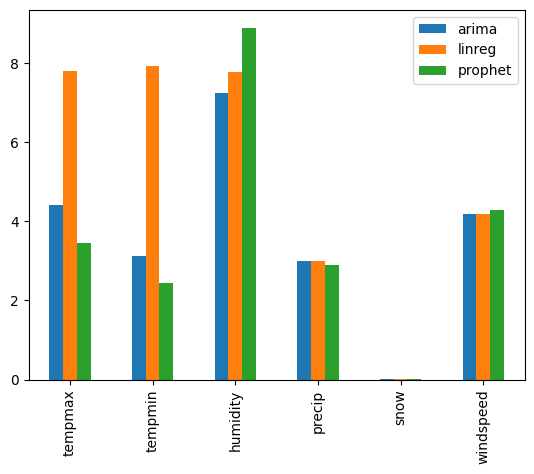

In [53]:
pd.concat([result_arima, result_linreg, result_prophet]).T.plot(kind='bar')

In [124]:
def isWorkday(date, workday):
    return (workday & pow(2, date.weekday())) != 0

In [143]:
weather_all.to_csv('data/weather_all.csv')

In [138]:
def assessWeather(start_date, end_date, workday, weather_data):
    select_weather = weather_data[start_date:end_date]
    count = 0
    warning = 0
    
    for date, row in select_weather.iterrows():
        if isWorkday(date, workday) :
            if row['heavy_weather'] == 1:
                warning += 1
            count += 1
    
    print(f'There are {count} workdays.')
    print(f'There are {warning} days with potential bad weather.')
    print(f'Severity score {warning/count*100:.2f}')
    
    return warning/count*100
    

In [141]:
assessWeather('2023-01-01', '2023-02-15',63,weather_all)

There are 39 workdays.
There are 3 days with potential bad weather.
Severity score 7.69


7.6923076923076925

In [145]:
weather_all

,tempmax,tempmin,temp,humidity,precip,snow,snowdepth,windspeed,conditions,description,raining,snowing,heavy_weather
datetime,,,,,,,,,,,,,
2020-01-01,32.833333,13.833333,20.833333,42.0,0.1524,0.0,0.0,21.243288,"rain, overcast",Cloudy skies throughout the day with early mor...,1,0,0
2020-01-02,32.777778,10.944444,20.166667,53.3,0.0000,0.0,0.0,23.818232,overcast,Cloudy skies throughout the day.,0,0,0
2020-01-03,37.055556,16.055556,25.555556,47.0,0.0000,0.0,0.0,27.680648,partially cloudy,Clearing in the afternoon.,0,0,1
2020-01-04,42.888889,18.888889,31.388889,38.8,0.0000,0.0,0.0,37.014820,partially cloudy,Partly cloudy throughout the day.,0,0,1
2020-01-05,26.611111,14.833333,18.777778,57.3,0.0000,0.0,0.0,27.036912,overcast,Cloudy skies throughout the day.,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-27,24.666667,10.444444,17.277778,63.2,6.8072,NaN,NaN,26.715044,partially cloudy,NaN,0,0,0
2024-11-28,26.055556,11.833333,18.666667,61.3,4.8006,NaN,NaN,28.807186,partially cloudy,NaN,0,0,0
2024-11-29,25.666667,12.333333,18.833333,60.1,5.4102,NaN,NaN,27.036912,partially cloudy,NaN,0,0,0
